# Modeling and Evaluation with baselines

This module is mainly responsible for classification and evaluation of the results. 

First of all have split the dataset of results in training and test taking into account that some rows must be only in the training set. More precisely from the reason on which we have create the baselines, we have analyzed all the previous matches played by that team, but in the case that the actual match is the first played match fot the team in that competition we coudn't have the baseline value. So there exists some rows in the dataset that the tuple (row\[matchId\], row\[teamId\]) is contained in a pre-evaluated set. All these lines are forced to be in the training set.

The test set is the 20% of the results dataset, hence the remaining 80% is the training set. On the training set we have done the __gridSearchCV__ with hypertuning parameters. This funtion also take as input the scoring metric, and we decide to evaluate it with __accuracy__, __f1__, __precision__ and __recall__. For the last three scoring metrics we have used the default __binary__ average for binary the target variables _isWinner_ and _didScoreInTWP_ , and the __macro__ average for the target variable _goalsDiff_ .

The baselines on we have test the models are described and created in the notebook named __Baselines__.

In [436]:
%load_ext autoreload
%autoreload 2

from collections import Counter
from hyperparameters import params as all_params
from hyperparameters import nanSet
from math import pi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import pymongo
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import shuffle
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# create the folde plots in which are saved the plots in pdf format
import os
if not os.path.exists('./plots'):
    os.mkdir('./plots')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
client = pymongo.MongoClient()
db = client['wyscout']

## Functions

In [272]:
targetsNames = [ 'isWinner', 'didScoreInTWP', 'goalsDiff' ] 

targets = [
    { 'name': 'isWinner', 'type': 'categorical' },
    { 'name': 'didScoreInTWP', 'type': 'categorical' },
    { 'name': 'goalsDiff', 'type': 'categorical' } 
]

algFunction = {
    'mlpC': MLPClassifier,
    'mlpR': MLPRegressor,
    'knC': KNeighborsClassifier,
    'svC': SVC,
    'svR': SVR,
    'linReg': LinearRegression,
    'rfC': RandomForestClassifier,
    'rfR': RandomForestRegressor,
    'dtC': DecisionTreeClassifier,
    'dtR': DecisionTreeRegressor
}

scoresFunction = {
    'accuracy': accuracy_score,
    'f1': f1_score,
    'precision': precision_score,
    'recall': recall_score
}

bsLabels = { x:y for x,y in [ z for z in zip([11,12,21,31,32], 
                                             ['baseline1_1', 'baseline1_2', 'baseline2_1', 'baseline3_1', 'baseline3_2']) ] }

bsForTarget = {
    0: [11, 12],
    1: [21],
    2: [31, 32]
}

scores = ['accuracy', 'f1', 'precision', 'recall']
scoresMultiCls = ['f1', 'precision', 'recall']

The function `getDFofBS` take as input:

- `bsNum`, the number that identify the baseline: __11__, __12__, __21__, __31__ or __32__
- `bs_col`, the collection of the baselines in the database

and returns a daframe composed by the columns of the _matchId, teamId_ and values of the baseline _bsNum_

In [4]:
def getDFofBS (bsNum, bs_col = db.baselines): 
    bs_col.find_one()
    if bsNum == 21:
        df_bs = pd.DataFrame([e for e in bs_col.find({ }, { '_id':0, 'matchId':1, 'teamId':1, 'baseline2_1.1H_2H':1 })])
        l = [ e['1H_2H'] for e in df_bs[bsLabels[bsNum]] ]
        df_bs[bsLabels[bsNum]] = l
    else:
        df_bs = pd.DataFrame([e for e in bs_col.find({ }, { '_id':0, 'matchId':1, 'teamId':1, bsLabels[bsNum]:1 })])

    df_bs = df_bs[['matchId', 'teamId', bsLabels[bsNum] ]].sort_values(by='matchId')
    return df_bs

The function `couplesMatchTeamNan` calls the function `getDFofBS` for each possible value of `bsNum` creating a dictionary that for each possible value of _bsNum_ stores the list of couples __(matchId, teamId)__ in which the values of the baseline is _NaN_. Then returns the set union of all the sets given from the list of each _bsNum_. 

This information is usefull to put all the rows for which the _matchId_ and the _teamId_ values are in the evaluated set, in the training set, avoiding so problems on the tests.

In [90]:
def couplesMatchTeamNan ():
    sets = dict()
    for x in bsLabels:
        df_bs = getDFofBS(x)
        df_null = df_bs[ df_bs[bsLabels[x]].isnull() ]
        y = { (str(row['matchId']), str(row['teamId'])) for i,row in df_null.iterrows() }
        sets.update( {x: y} )
    
    set_ = set()
    for x in sets:
        s = sets[x]
        set_ = set_.union(s)
    
    return list(set_)

The function `addBStoDF` take as input:

- `df`, a dataframe that contains at least a column of _matchId_ and one of _teamId_

and returns a daframe composed by all the columns of the input dataframe _df_ plus all the columns of the baselines

In [6]:
def addBStoDF (df):
    df_ = df
    for i in bsLabels:
        df_ = pd.merge(df_, getDFbs(i), on=['matchId', 'teamId'])
    return df

# <font color=red> 1. Models evaluation</font>

The function `dfTargetVar` take as input:
- `df`, the dataframe of our results
- `targetId`, the number of the target variable that we want analyze: __0__ for `isWinner`, __1__ for `didScoreInTWP` and __2__ for `goalsDiff`
- `algs`, the list of 'nicknames' of the algorithms applyed for the classification
- `colsDrop`, the list of the column names that we want drop from dataset before the clasification

and returns a dataframe where each line reports the name of the algorithm applied, the best parameters and the scoring used for the GridSeachCV function, also the values of _accuracy, f1, precision_ and _recall_ obtained evaluating the classifier on the text pasr of the dataset.

In [107]:
def dfTargetVar (df, targetId = 0, algs = [], colsDrop = [], avg='macro'):
    targetName = targets[targetId]['name']
    targetType = targets[targetId]['type']
    
    Xtr = pd.DataFrame(columns=df.columns) # it will store the rows of which (matchId, teamId) have a NaN value in our baselines
    Xts = pd.DataFrame(columns=df.columns) # it will store all the other rows - THAT WILL BE SPLIT
    for i, row in df.iterrows():
        if (str(int(row['matchId'])), str(int(row['teamId']))) in nanSet:
            Xtr = Xtr.append(row)
        else:
            Xts = Xts.append(row)

    ytr = Xtr[targetName] #target column from Xtr
    yts = Xts[targetName] #target column from Xts - THAT WILL BE SPLIT

    Xts, yts = shuffle(Xts, yts, random_state=0) #THESE WILL BE SPLIT
    X_train, X_test, y_train, y_test = train_test_split( Xts, yts, test_size=0.19 ) #SPLIT

    X_train = pd.concat([X_train, Xtr], ignore_index=True)
    y_train = np.asarray(pd.concat([y_train, ytr], ignore_index=True),dtype=np.float64)
    y_test = np.asarray(y_test, dtype=np.float64)
    
    
    
    bsArray = { k: np.asarray(X_test[bsLabels[k]], dtype=np.float64) for k in bsForTarget[targetId] }

    colsDrop = colsDrop + [ bsLabels[k] for k in bsLabels ]
    X_train = X_train.drop(targetsNames + colsDrop + ['teamId', 'matchId'], axis=1)
    X_test = X_test.drop(targetsNames + colsDrop + ['teamId', 'matchId'], axis=1)
    
    XX = pd.concat([X_train, X_test], ignore_index=True)
    XX = StandardScaler().fit_transform(XX)

    X_train = XX[0:len(X_train)]
    X_test = XX[len(X_train):len(X_train)+len(X_test)]
    
    '''    
    X = df.drop(targetsNames, axis=1)
    y = df[targetName]
    X = StandardScaler().fit_transform(X)
    
    X, y = shuffle(X, y, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2 )
    '''
    
    results = []
    
    for alg in algs:
        if all_params[alg]['type'] == targetType :
            startA = time.time()
            print(alg)
            algParams = all_params[alg]['params']
            
            if targetId == 2:
                scoresGSCV = ['accuracy'] + [ '{}_{}'.format(e, avg) for e in ['f1', 'precision', 'recall'] ]
            else:
                scoresGSCV = ['accuracy', 'f1', 'precision', 'recall'] 
                
            for i in range(0, len(scoresGSCV)):
                print('\t%s' %scoresGSCV[i], end='')
                startS = time.time()
                
                if targetId == 2:
                    clf = GridSearchCV(algFunction[alg](), algParams, cv=5, scoring=scoresGSCV[i])
                    clf.fit(X_train, y_train)
                    
                    scRes = { sc: make_scorer(scoresFunction[sc], average='macro')(clf, X_test, y_test) for sc in scoresMultiCls }
                    scRes.update({ 'accuracy': make_scorer(scoresFunction['accuracy'])(clf, X_test, y_test)})
                    
                    scBas1 = { 'bs_{}_{}'.format(k, sc): scoresFunction[sc](bsArray[k], clf.predict(X_test), average='macro') 
                              for k in bsForTarget[targetId] for sc in scoresMultiCls }
                    scBas2 = { 'bs_{}_{}'.format(k, sc): scoresFunction[sc](bsArray[k], clf.predict(X_test)) 
                              for k in bsForTarget[targetId] for sc in ['accuracy'] }
                    scBas = { **scBas1, **scBas2 }
                    
                else:
                    clf = GridSearchCV(algFunction[alg](), algParams, cv=5, scoring=scoresGSCV[i])
                    clf.fit(X_train, y_train)
                    
                    scRes = { sc: make_scorer(scoresFunction[sc])(clf, X_test, y_test) for sc in scores }
                
                    scBas = { 'bs_{}_{}'.format(k, sc): scoresFunction[sc](bsArray[k], clf.predict(X_test)) 
                              for k in bsForTarget[targetId] for sc in scores }
                
                results.append( { 
                    'algorithm': alg, 'bestParams': clf.best_params_, 'scoringParam': scoresGSCV[i],
                    #'f1': scRes['f1'], 'accuracy': scRes['accuracy'], 'precision': scRes['precision'], 'recall': scRes['recall'], 
                    **scRes, **scBas } )
                print(' done in %.2f sec' %(time.time()-startS) )
            print('\tTime elapsed for this algorithm: %.2f' %(time.time()-startA) )    
    
    cols = ['algorithm', 'bestParams', 'scoringParam', 'f1', 'accuracy', 'precision', 'recall'] + [ 'bs_{}_{}'.format(k, sc) for k in bsForTarget[targetId] for sc in scores ]
    df_res = pd.DataFrame(results, columns = cols )
    
    return df_res 

## <font color=orange> 1.1 Run the models evaluation for a target variable</font>


The function `runForTarget` take as input:

- `data`, the dataframe of results griven by the _data understanding_ phase of the project
- `targetId`, the number of the target variable that we want analyze: __0__ for `isWinner`, __1__ for `didScoreInTWP` and __2__ for `goalsDiff`
- `outNameFile`, the name of the file in which save the results

it calls the function `dfTargetVar` on the data
- without the columns: _numGoals1H, numGoals2H, numGoalsET, finalScore, numGoalsTWP_ and *numOwnGoalsTWP*,
- and for the classifiers: __MLPClassifier__, __KNeighborsClassifier__, __SVC__ and __DecisionTreeClassifier__.

and save in the actual directory a json file with name _outNameFile_ if it is given or with name _modelRes\_`targetId`_

In [108]:
def runForTarget (data, targetId, outNameFile='' ):
    print('TARGET: %s' %targetId)
    
    if outNameFile == '':
        outNameFile = 'modelRes_{}'.format(targetId)
    
    colsDrop_ = ['numGoals1H', 'numGoals2H', 'numGoalsET', 'finalScore',
                 'numGoalsTWP', 'numOwnGoalsTWP']
    
    algs_ = ['mlpC', 'knC', 'svC', 'dtC']
    df_res = dfTargetVar(data, targetId=targetId, algs=algs_, colsDrop=colsDrop_)
    df_res.to_json('./{}.json'.format(outNameFile), orient='records')

In [109]:
#data = pd.DataFrame(list(db.res_1H_2H.find({ }, { '_id': 0 })))
data = pd.read_json('./dataForModelsBS.json', orient='records')
runForTarget(data, 0, outNameFile='provaModel')

TARGET: 0
mlpC
	accuracy done in 45.29 sec
	f1 done in 44.41 sec
	precision done in 44.70 sec
	recall done in 44.50 sec
	Time elapsed for this algorithm: 178.91
knC
	accuracy done in 9.56 sec
	f1 done in 9.48 sec
	precision done in 9.61 sec
	recall done in 9.95 sec
	Time elapsed for this algorithm: 38.62


In [4]:
def dfFromJsonRes (t, fileName='', orient_='records'):
    if fileName != '':
        df = pd.read_json('./{}.json'.format(fileName), orient=orient_)
    else:
        df = pd.read_json('./modelRes_{}.json'.format(t), orient=orient_)
        
    cols = ['algorithm', 'bestParams', 'scoringParam'] + scores + [ 'bs_{}_{}'.format(k, sc) for k in bsForTarget[t] for sc in scores ]
    return df[cols]

In [374]:
res0_ = dfFromJsonRes(0)
res0_

,algorithm,bestParams,scoringParam,accuracy,f1,precision,recall,bs_11_accuracy,bs_11_f1,bs_11_precision,bs_11_recall,bs_12_accuracy,bs_12_f1,bs_12_precision,bs_12_recall
0,mlpC,"{'activation': 'logistic', 'hidden_layer_sizes...",accuracy,0.749634,0.620843,0.679612,0.571429,0.698389,0,0,0,0.679356,0.406504,0.364078,0.460123
1,mlpC,"{'activation': 'logistic', 'hidden_layer_sizes...",f1,0.742313,0.636364,0.644351,0.628571,0.650073,0,0,0,0.669107,0.437811,0.368201,0.539877
2,mlpC,"{'activation': 'logistic', 'hidden_layer_sizes...",precision,0.745242,0.625000,0.662100,0.591837,0.679356,0,0,0,0.680820,0.429319,0.374429,0.503067
3,mlpC,"{'activation': 'logistic', 'hidden_layer_sizes...",recall,0.748170,0.630901,0.665158,0.600000,0.676428,0,0,0,0.677892,0.427083,0.371041,0.503067
4,knC,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",accuracy,0.726208,0.551559,0.668605,0.469388,0.748170,0,0,0,0.708638,0.405970,0.395349,0.417178
5,knC,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",f1,0.726208,0.551559,0.668605,0.469388,0.748170,0,0,0,0.708638,0.405970,0.395349,0.417178
6,knC,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",precision,0.726208,0.551559,0.668605,0.469388,0.748170,0,0,0,0.708638,0.405970,0.395349,0.417178
7,knC,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",recall,0.724744,0.548077,0.666667,0.465306,0.749634,0,0,0,0.707174,0.401198,0.391813,0.411043
8,svC,"{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}",accuracy,0.745242,0.593458,0.693989,0.518367,0.732064,0,0,0,0.692533,0.393064,0.371585,0.417178
9,svC,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",f1,0.752562,0.615034,0.695876,0.551020,0.715959,0,0,0,0.688141,0.403361,0.371134,0.441718


In [375]:
res1_ = dfFromJsonRes(1)
res1_

,algorithm,bestParams,scoringParam,accuracy,f1,precision,recall,bs_21_accuracy,bs_21_f1,bs_21_precision,bs_21_recall
0,mlpC,"{'activation': 'logistic', 'hidden_layer_sizes...",accuracy,0.597365,0.655820,0.617925,0.698667,0.379209,0,0,0
1,mlpC,"{'activation': 'tanh', 'hidden_layer_sizes': [...",f1,0.607613,0.629834,0.653295,0.608000,0.489019,0,0,0
2,mlpC,"{'activation': 'logistic', 'hidden_layer_sizes...",precision,0.595900,0.625000,0.637119,0.613333,0.471449,0,0,0
3,mlpC,"{'activation': 'relu', 'hidden_layer_sizes': [...",recall,0.585652,0.628121,0.619171,0.637333,0.434846,0,0,0
4,knC,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",accuracy,0.572474,0.610667,0.610667,0.610667,0.450952,0,0,0
5,knC,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",f1,0.572474,0.610667,0.610667,0.610667,0.450952,0,0,0
6,knC,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",precision,0.572474,0.610667,0.610667,0.610667,0.450952,0,0,0
7,knC,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",recall,0.572474,0.610667,0.610667,0.610667,0.450952,0,0,0
8,svC,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",accuracy,0.606149,0.635007,0.646409,0.624000,0.469985,0,0,0
9,svC,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}",f1,0.549048,0.708885,0.549048,1.000000,0.000000,0,0,0


In [413]:
res2_ = dfFromJsonRes(2)
res2_

,algorithm,bestParams,scoringParam,accuracy,f1,precision,recall,bs_31_accuracy,bs_31_f1,bs_31_precision,bs_31_recall,bs_32_accuracy,bs_32_f1,bs_32_precision,bs_32_recall
0,mlpC,"{'activation': 'logistic', 'hidden_layer_sizes...",accuracy,0.286969,0.099673,0.098551,0.116830,0.339678,0.110008,0.111394,0.120779,0.329429,0.160102,0.168882,0.164768
1,mlpC,"{'activation': 'relu', 'hidden_layer_sizes': [...",f1_macro,0.260615,0.107776,0.095030,0.126319,0.333821,0.111186,0.105260,0.137733,0.327965,0.127812,0.125116,0.146834
2,mlpC,"{'activation': 'tanh', 'hidden_layer_sizes': [...",precision_macro,0.272328,0.127663,0.128652,0.139268,0.316252,0.106746,0.109361,0.120611,0.317716,0.113626,0.111730,0.128931
3,mlpC,"{'activation': 'tanh', 'hidden_layer_sizes': [...",recall_macro,0.272328,0.132275,0.173363,0.144725,0.338214,0.118409,0.120761,0.142128,0.313324,0.123907,0.122163,0.140824
4,knC,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",accuracy,0.248902,0.105621,0.122421,0.108852,0.298682,0.107318,0.108984,0.110187,0.292826,0.121651,0.121801,0.127401
5,knC,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",f1_macro,0.193265,0.096038,0.097282,0.097097,0.241581,0.085417,0.092282,0.083601,0.243045,0.086047,0.093249,0.088144
6,knC,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",precision_macro,0.248902,0.105621,0.122421,0.108852,0.298682,0.107318,0.108984,0.110187,0.292826,0.121651,0.121801,0.127401
7,knC,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",recall_macro,0.193265,0.096038,0.097282,0.097097,0.241581,0.085417,0.092282,0.083601,0.243045,0.086047,0.093249,0.088144
8,svC,"{'C': 0.1, 'kernel': 'linear'}",accuracy,0.288433,0.104458,0.130672,0.122432,0.333821,0.108578,0.185673,0.120462,0.357247,0.140589,0.235361,0.150802
9,svC,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",f1_macro,0.282577,0.121855,0.136342,0.122960,0.304539,0.095480,0.098279,0.097487,0.316252,0.094777,0.097394,0.096225


# <font color=red> 2. Plots</font>

The functions `getScoreValsForTV` and `getScoreValsForTVandBS` both take as input
- a dataframe `df` and 
- a scoring parameter `sc`, 
- the second one also take as input the number relative to a baseline `bs` (eg. 11, 12, 21, 31 or 32). 

The first function returns a list of _#modelsExecuted_ lits, where each one contains 4 values, one for each score metric evaluated. The second function return the same output but take the score metric evaluated on the baseline _bs_.

In [424]:
def getScoreValsForTV (df, sc):
    df = df.sort_values(by='algorithm')
    lbls = []
    vals = []
    for i, row in df.iterrows():
        if row['scoringParam'] == sc:
            lbls.append(row['algorithm'].upper())
            vals.append( [ row[x] for x in ['accuracy', 'f1', 'precision', 'recall'] ])
    return vals, lbls

def getScoreValsForTVandBS (df, sc, bs):
    df = df.sort_values(by='algorithm')
    lbls = []
    vals = []
    for i, row in df.iterrows():
        if row['scoringParam'] == sc:
            lbls.append(row['algorithm'].upper())
            vals.append( [ row[x] for x in [ 'bs_{}_{}'.format(bs, sc) for sc in ['accuracy', 'f1', 'precision', 'recall'] ] ])
    return vals, lbls

## <font color=orange> 2.1 Radar plots of scores</font>


The function `plotScores` take as input:

- `values`, the output of function `getScoreValsForTV`
- `scores`, list of the score metrics evaluated on the models
- `labels`, list the labels of the legend, that corresponds to the models tested
- `title`, the title of the plot
- `save`, boolean value, True if you want save the plot, False if you want only show it
- `nameFile`, the name of the file in which save the plot
- `ex`, the extention of the file (eg. 'png' or 'pdf')

and returns the __radar plot__ of the scores evaluated on the models.

In [393]:
def plotScores(values, scores, labels, title='', save=False, nameFile='', ex='png'):
    if not len(values[0]) == len(scores) == 4:
        print('Each list in values and the list labels must have the same length.')
        return
    if not len(values) == len(labels):
        print('Input values and labels must be lists of same length.')
        return
    
    #DATA MANIPULATION
    categories=[s.title() for s in scores]
    N = len(categories)
    for v in values:
        v.extend(v[:1])
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    #FIGURE
    f = plt.figure(figsize=(6,6))
    ax = f.add_subplot(111, polar=True)
    #PLOTS
    i = 0
    for v in values:
        ax.plot(angles, v, '-', linewidth=2, linestyle='solid', label=labels[i])
        ax.fill(angles, v, alpha=0.1)
        i += 1
    #LABELS
    ax.text(0, 1.05, categories[0], va='bottom', ha='center', rotation_mode="anchor", rotation=-90, size=14)
    ax.text(pi/2, 1.05, categories[1], va='bottom', ha='center', rotation_mode="anchor", rotation=0, size=14)
    ax.text(pi, 1.05, categories[2], va='bottom', ha='center', rotation_mode="anchor", rotation=90, size=14)
    ax.text(3/2*pi, 1.05, categories[3], va='top', ha='center', rotation_mode="anchor", rotation=0, size=14)
    #TICKS
    plt.xticks(angles[:-1], [], size=14)
    ax.set_rlabel_position(20)
    plt.yticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1], ['',"0.2",'',"0.4",'',"0.6",'',"0.8",'',"1"], 
               ha='center', size=12, color='gray', fontweight="bold")
    plt.ylim(0,1)
    
    
    #TITLE
    #ax.text(2.25/3*pi, 1.5, 'didScoreInTWP', ha='left', rotation_mode="anchor", rotation=0, size=13, fontweight="bold")
    ax.text(pi/2, 1.25, title, ha='center', rotation_mode="anchor", rotation=0, size=13, fontweight="bold")
    #LEGEND
    plt.legend(bbox_to_anchor=(1.07, 1.07), fontsize=8)
    #SAVE
    if save:
        plt.savefig('plots/{}.{}'.format(nameFile, ex), bbox_inches = "tight")
    else:
        plt.show()
    

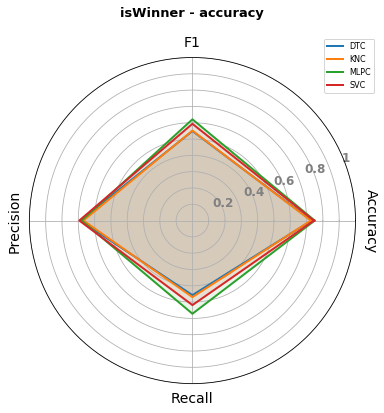

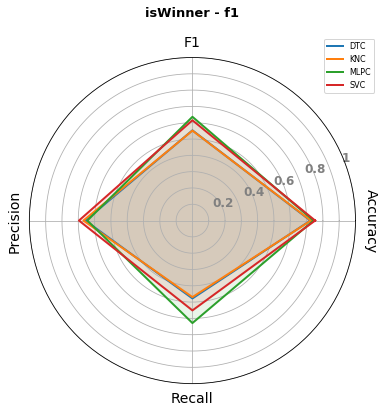

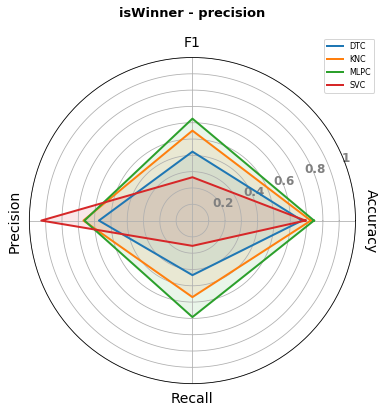

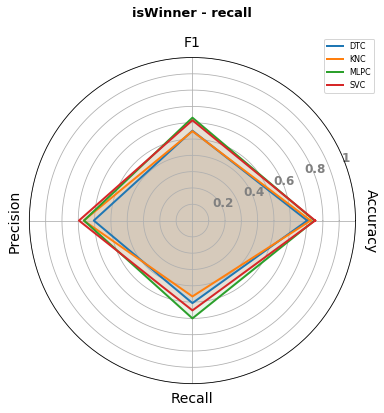

In [394]:
scs = ['accuracy', 'f1', 'precision', 'recall']
for sc in scs:
    vals, lbs = getScoreValsForTV(dfFromJsonRes(0), sc)
    plotScores(vals, scs, lbs, 'isWinner - {}'.format(sc))

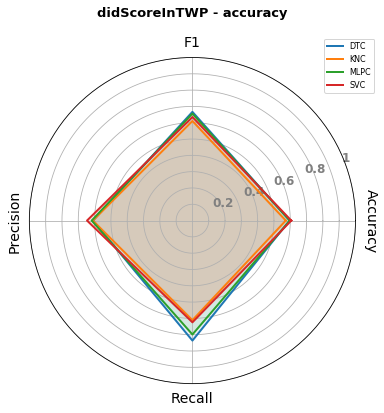

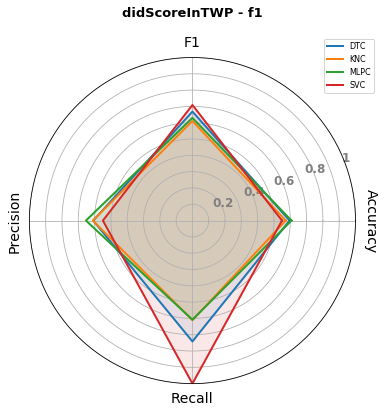

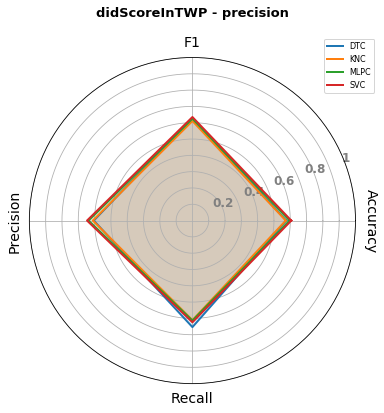

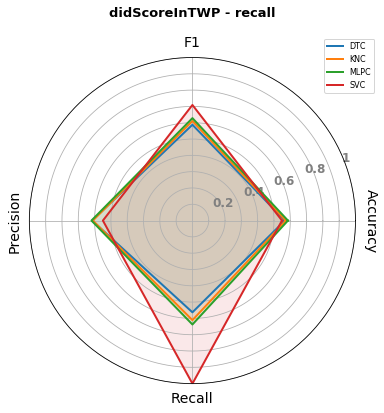

In [396]:
for sc in scs:
    vals, lbs = getScoreValsForTV(dfFromJsonRes(1), sc)
    plotScores(vals, scs, lbs, 'didScoreInTWP - {}'.format(sc))

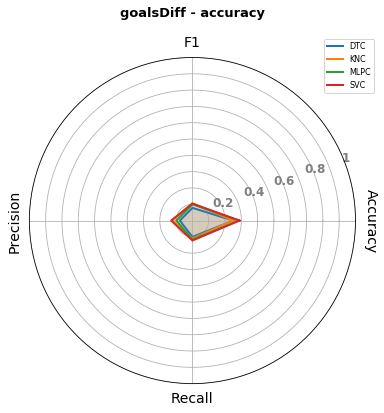

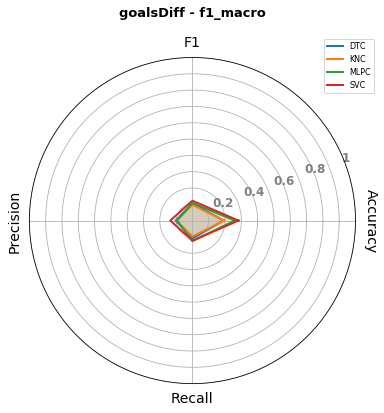

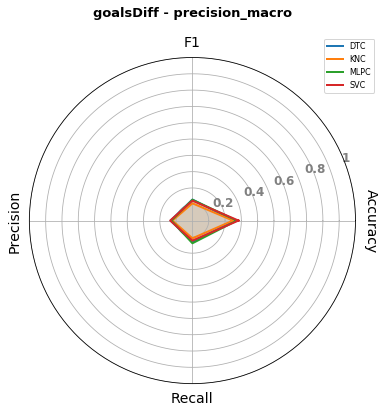

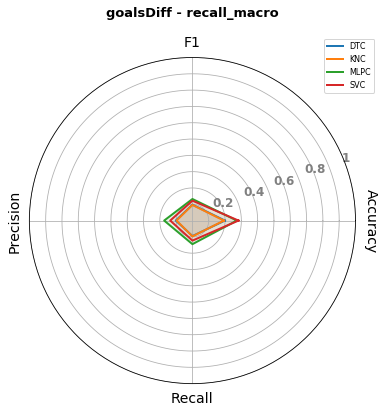

In [414]:
scsMultiCls = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
for sc in scsMultiCls:
    vals, lbs = getScoreValsForTV(dfFromJsonRes(2), sc)
    plotScores(vals, scs, lbs, 'goalsDiff - {}'.format(sc))

## <font color=orange> 2.2 Line plots of scores</font>


The function `plotScoresLines` take as input:

- `values`, the output of function `getScoreValsForTV`
- `scores`, list of the score metrics evaluated on the models
- `labels`, list the labels of the legend, that corresponds to the models tested
- `title`, the title of the plot
- `save`, boolean value, True if you want save the plot, False if you want only show it
- `nameFile`, the name of the file in which save the plot
- `ex`, the extention of the file (eg. 'png' or 'pdf')

and returns the __line plot__ of the scores evaluated on the models.

In [403]:
def plotScoresLines(values, scores, labels, title='', save=False, nameFile='', ex='png'):

    fig, ax = plt.subplots(figsize=(6,4.5))
    #PLOTS
    i=0
    for v in values:
        ax.plot(v, 'o-', label=labels[i], alpha=0.7)
        i += 1
    #LABELS
    ax.grid(axis='y')
    plt.ylim(0,1)
    plt.xticks([0,1,2,3], [ e.title() for e in scs ], fontsize=14)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    #LEGEND
    loc_ = 'lower center'
    if min(min(vals)) < 0.2 :
        loc_ = 'upper center'
    plt.legend(loc=loc_, fontsize=8)
    #SAVE
    if save:
        plt.savefig('plots/{}.{}'.format(nameFile, ex), bbox_inches = "tight")
    else:
        plt.show()

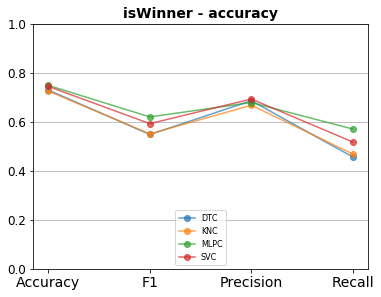

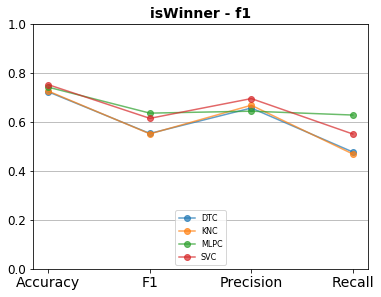

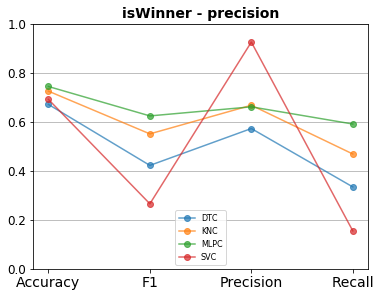

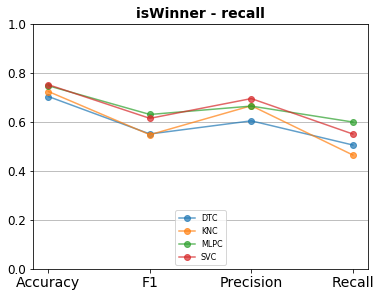

In [404]:
scs = ['accuracy', 'f1', 'precision', 'recall']
for sc in scs:
    vals, lbs = getScoreValsForTV(dfFromJsonRes(0), sc)
    plotScoresLines(vals, scs, lbs, 'isWinner - {}'.format(sc))

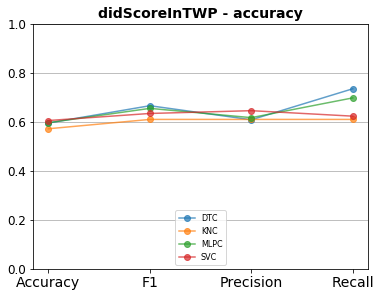

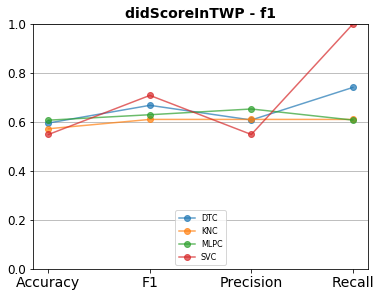

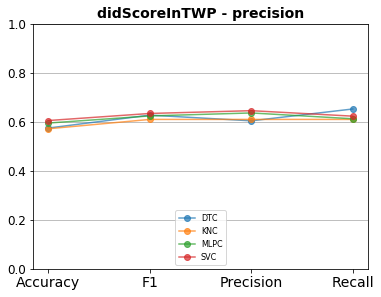

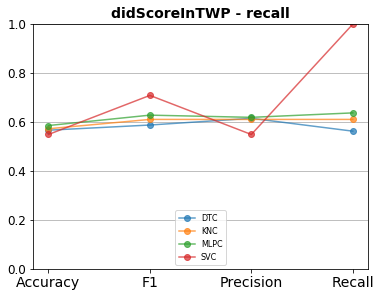

In [405]:
for sc in scs:
    vals, lbs = getScoreValsForTV(dfFromJsonRes(1), sc)
    plotScoresLines(vals, scs, lbs, 'didScoreInTWP - {}'.format(sc))

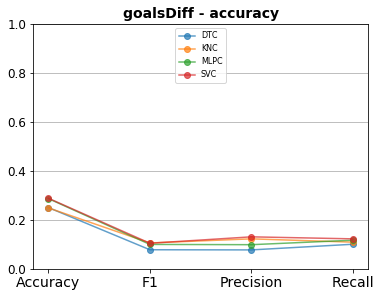

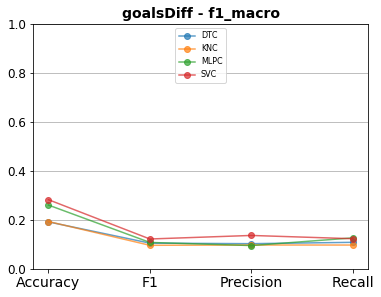

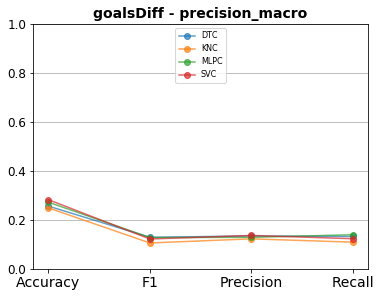

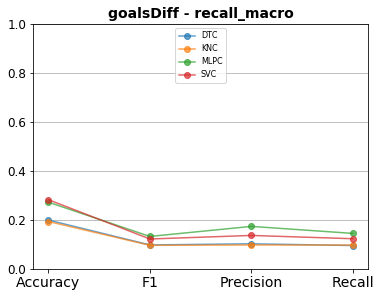

In [415]:
scsMultiCls = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
for sc in scsMultiCls:
    vals, lbs = getScoreValsForTV(dfFromJsonRes(2), sc)
    plotScoresLines(vals, scs, lbs, 'goalsDiff - {}'.format(sc))

## <font color=orange> 2.3 Line plots of baselines scores</font>


The function `plotScoresBSLines` take as input:

- `valuesDict`, a dictionary that looks like { _baselineNum_ : the output of function `getScoreValsForTVandBS` for _baselineNum_ }
- `scores`, list of the score metrics evaluated on the models
- `labels`, list the labels of the legend, that corresponds to the models tested
- `title`, the title of the plot
- `save`, boolean value, True if you want save the plot, False if you want only show it
- `nameFile`, the name of the file in which save the plot
- `ex`, the extention of the file (eg. 'png' or 'pdf')

and returns the __line plot__ of the scores evaluated on the baseline/s for that target variable.

In [362]:
def plotScoresBSLines(valuesDict, scores, labels, title='', save=False, nameFile='', ex='png'):

    fig, ax = plt.subplots(figsize=(6,4.5))
    lineSty = { 0: 'o-', 1: 'x--' }
    #PLOTS
    for i in range(0, len(labels)):
        color_ = 'C{}'.format(i)
        j = 0
        for bs in valuesDict.keys():
            ax.plot(valuesDict[bs][i], lineSty[j], color=color_, alpha=0.7, label='{}_{}'.format(labels[i], bs))
            j += 1
    #LABELS
    ax.grid(axis='y')
    plt.ylim(0,1)
    plt.xticks([0,1,2,3], [ e.title() for e in scs ], fontsize=14)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    #LEGEND
    loc_ = 'upper right'
    plt.legend(loc=loc_, fontsize=8)
    #SAVE
    if save:
        plt.savefig('plots/{}.{}'.format(nameFile, ex), bbox_inches = "tight")
    else:
        plt.show()

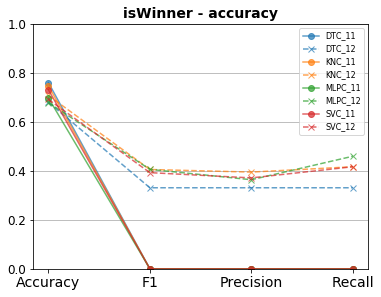

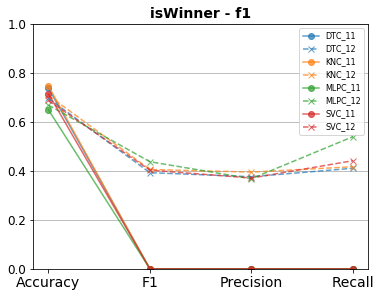

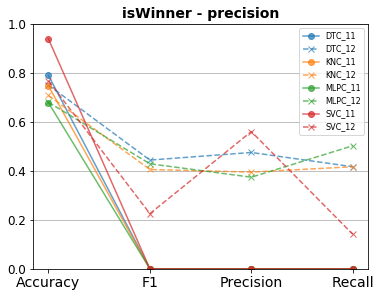

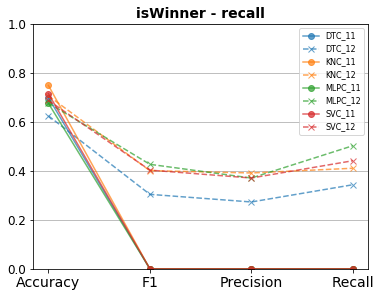

In [426]:
scs = ['accuracy', 'f1', 'precision', 'recall']
for sc in scs:
    x, lbs = getScoreValsForTVandBS(dfFromJsonRes(0), 'accuracy', bsForTarget[0][0])
    vals = { bs: getScoreValsForTVandBS(dfFromJsonRes(0), sc, bs)[0] for bs in bsForTarget[0] }
    plotScoresBSLines(vals, scs, lbs, 'isWinner - {}'.format(sc))

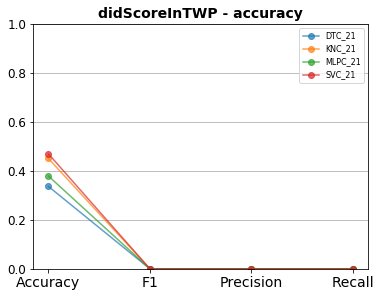

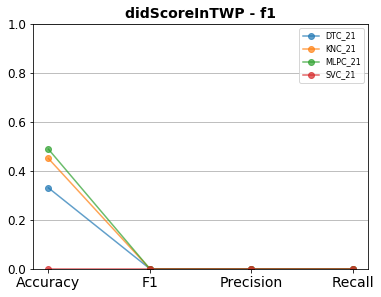

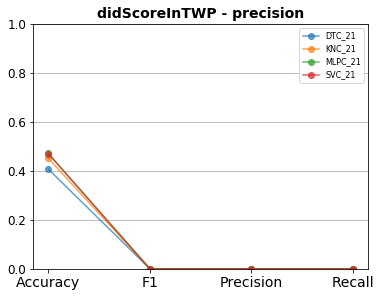

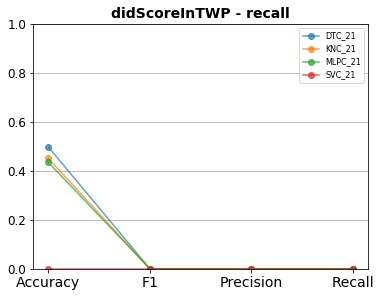

In [429]:
for sc in scs:
    x, lbs = getScoreValsForTVandBS(dfFromJsonRes(1), 'accuracy', bsForTarget[1][0])
    vals = { bs: getScoreValsForTVandBS(dfFromJsonRes(1), sc, bs)[0] for bs in bsForTarget[1] }
    plotScoresBSLines(vals, scs, lbs, 'didScoreInTWP - {}'.format(sc))

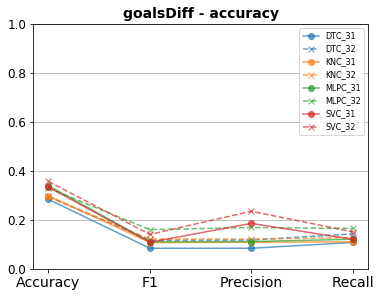

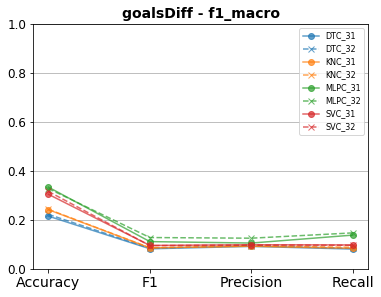

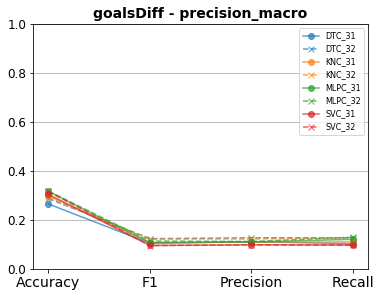

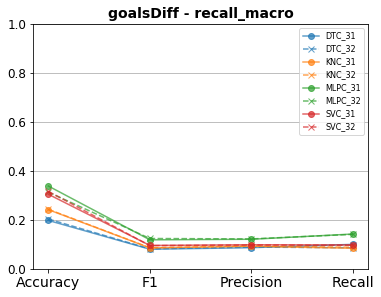

In [433]:
scsMultiCls = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
for sc in scsMultiCls:
    x, lbs = getScoreValsForTVandBS(dfFromJsonRes(2), 'accuracy', bsForTarget[2][0])
    vals = { bs: getScoreValsForTVandBS(dfFromJsonRes(2), sc, bs)[0] for bs in bsForTarget[2] }
    plotScoresBSLines(vals, scs, lbs, 'goalsDiff - {}'.format(sc))